## Практическое задание к уроку № 1 по теме "Основы обучения нейронных сетей".

*Видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом,  
чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети?  
Что приводит к увеличению ее точности?*

Возьмём за основу код с урока и для удобства напишем функцию  
с подстановкой гиперпараметров:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

In [3]:
# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(sigm):
    return sigm * (1 - sigm)

In [4]:
# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [5]:
# Подготовка тренировочных данных

# получение данных из csv файла
iris_data = pd.read_csv("../../Теория/Lesson_1/Iris.csv")

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
X = pd.DataFrame(iris_data, columns=columns)
X = normalize(X.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=29)

In [6]:
def train_nn(n_iter=1000, eta=0.1, n2=5):

    '''
    
        n_iter - число итераций,
        eta - learning rate,
        n2 - кол-во нейронов 2-го слоя
        
    '''

    # Обученние нейронной сети

    # присваивание случайных весов
    np.random.seed(1)
    w0 = 2*np.random.random((4, n2)) - 1 # для входного слоя - 4 входа, n2 выходов
    w1 = 2*np.random.random((n2, 3)) - 1 # для внутреннего слоя - n2 входов, 3 выхода

    # скорость обучения (learning rate)
    n = eta

    # процесс обучения
    for i in range(n_iter):

        # прямое распространение(feed forward)
        layer0 = X_train.copy()
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2
        layer2_delta = np.sign(layer2_error) * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n

    return w0, w1

Оценивать будем на тестовых данных:

In [7]:
def predict_nn(X_test, y_test, weights):
    
    w0, w1 = weights
    layer_1 = sigmoid(np.dot(X_test, w0))
    output = sigmoid(np.dot(layer_1, w1))
    error = np.mean(abs(y_test - output))
    return error

Сначала оценим влияние количества итераций на величину ошибки:

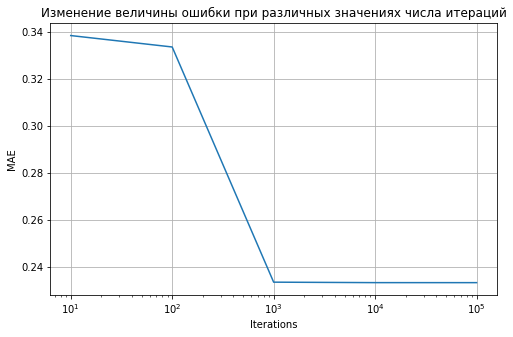

In [8]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 5))

iters = (10, 100, 1000, 10000, 100000)
err = []

for n in iters:
    weights = train_nn(n_iter=n)
    err.append(predict_nn(X_test, y_test, weights))

plt.plot(iters, err)
plt.title('Изменение величины ошибки при различных значениях числа итераций')
plt.xlabel('Iterations')
plt.xscale(value='log')
plt.ylabel('MAE')
plt.grid()
plt.show()

Видно, что сначала величина ошибки падает с увеличением количества итераций,  
однако, число итераций выше 1000 уже не оказывает влияния на ошибку.

Оценим влияние коэффициента скорости обучения:

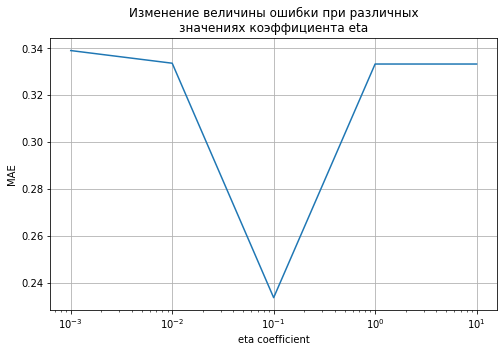

In [9]:
plt.figure(figsize=(8, 5))

etas = (0.001, 0.01, 0.1, 1, 10)
err = []

for eta in etas:
    weights = train_nn(eta=eta)
    err.append(predict_nn(X_test, y_test, weights))

plt.plot(etas, err)
plt.title('Изменение величины ошибки при различных\nзначениях коэффициента eta')
plt.xlabel('eta coefficient')
plt.xscale(value='log')
plt.ylabel('MAE')
plt.grid()
plt.show()

Величина коэффициента обучения 0.1 даёт минимальную ошибку.

Теперь будем менять количество нейронов 2 слоя:

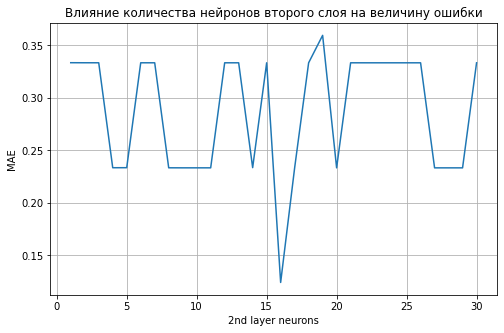

In [10]:
plt.figure(figsize=(8, 5))

n2s = np.arange(1, 31)
err = []

for n2 in n2s:
    weights = train_nn(n2=n2)
    err.append(predict_nn(X_test, y_test, weights))

plt.plot(n2s, err)
plt.title('Влияние количества нейронов второго слоя на величину ошибки')
plt.xlabel('2nd layer neurons')
plt.ylabel('MAE')
plt.grid()
plt.show()

В основном, на всём протяжении величина ошибки колеблется между  
двумя значениями. Однако когда нейронов второго слоя 16, мы имеем  
локальный минимум ошибки.

<ins>Вывод:</ins>
В результате проведённого исследования, оптимальными параметрами  
оказались:  
- Число итераций: 1000;  
- Скорость обучения: 0.1;  
- Количество нейронов второго слоя: 16.